In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy import interp
from itertools import cycle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import expon, randint, uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb


In [ ]:
data = pd.read_csv('/content/new-data.csv')

In [ ]:
data.head()

In [ ]:
# Remove previous grades
data = data.drop(columns=['G1', 'G2', 'G3'])
grade_category_unique_values = data['Grade_Category'].unique()

data_types = data.dtypes
grade_category_unique_values, data_types

In [ ]:
# encoding cat variables
le = LabelEncoder()
columns_to_encode = data.select_dtypes(include=['object']).columns.drop('Grade_Category')
for column in columns_to_encode:
    data[column] = le.fit_transform(data[column])
data.head()

In [ ]:
# Data preparation for ANOVA
# Convert 'Grade_Category' to a numeric value for ANOVA
data['Grade_Category_Num'] = le.fit_transform(data['Grade_Category'])
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
feature_pairs = itertools.combinations(numeric_columns.drop('Grade_Category_Num'), 2)
anova_results = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'F-Statistic', 'p-Value'])
for pair in feature_pairs:
    formula = f'Grade_Category_Num ~ C({pair[0]}) + C({pair[1]}) + C({pair[0]}):C({pair[1]})'
    model = ols(formula, data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    interaction_effect = aov_table.loc[f'C({pair[0]}):C({pair[1]})']
    if interaction_effect['PR(>F)'] < 0.05:
        new_row = pd.DataFrame({
            'Feature_1': [pair[0]],
            'Feature_2': [pair[1]],
            'F-Statistic': [interaction_effect['F']],
            'p-Value': [interaction_effect['PR(>F)']]
        })
        anova_results = pd.concat([anova_results, new_row], ignore_index=True)

In [ ]:
# Sort results by F-Statistic
anova_results_sorted = anova_results.sort_values(by='F-Statistic', ascending=False)
anova_results_sorted.head()


<ipython-input-7-364e3d0a42fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_anova_results['Interaction'] = top_anova_results['Feature_1'] + ' & ' + top_anova_results['Feature_2']


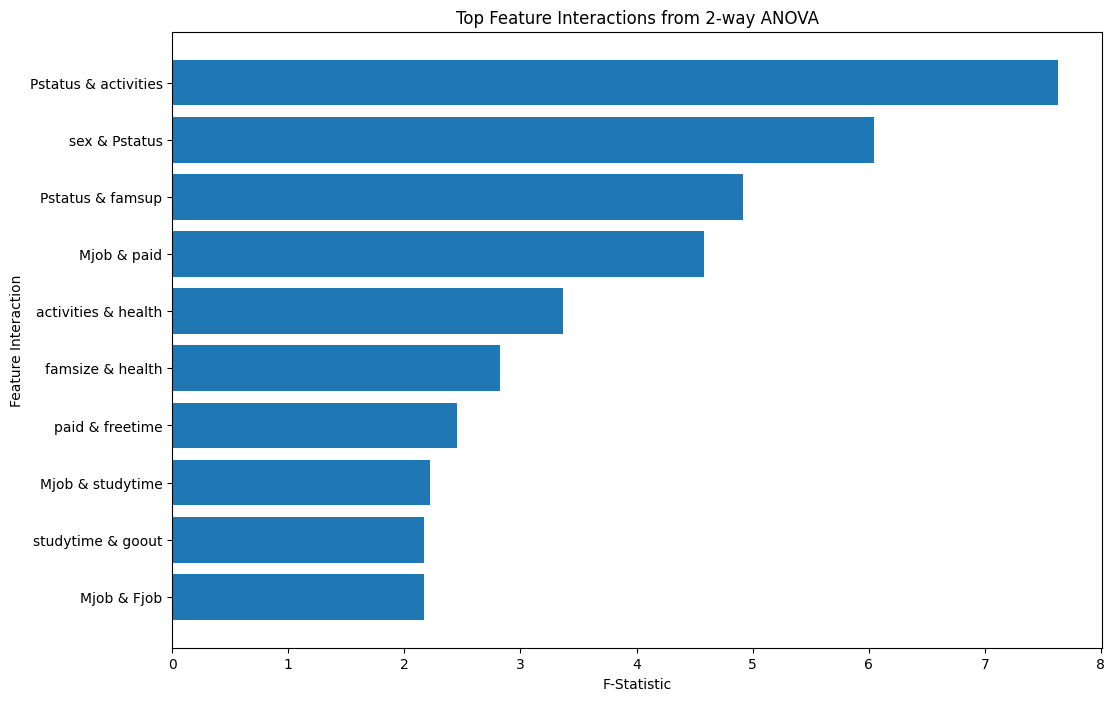

In [ ]:
top_anova_results = anova_results_sorted.head(10)
top_anova_results['Interaction'] = top_anova_results['Feature_1'] + ' & ' + top_anova_results['Feature_2']

# Plotting the F-Statistics for top ANOVA results
plt.figure(figsize=(12, 8))
plt.barh(top_anova_results['Interaction'], top_anova_results['F-Statistic'])
plt.xlabel('F-Statistic')
plt.ylabel('Feature Interaction')
plt.title('Top Feature Interactions from 2-way ANOVA')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Add Anova Features to df
for index, row in top_anova_results.iterrows():
    feature_1 = row['Feature_1']
    feature_2 = row['Feature_2']
    interaction_feature_name = f'{feature_1}_x_{feature_2}'
    data[interaction_feature_name] = data[feature_1] * data[feature_2]
data.head()


In [ ]:
X = data.drop(columns=['Grade_Category', 'Grade_Category_Num'])
y = data['Grade_Category_Num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and select the top features
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
top_features = feature_importances.nlargest(20, 'Importance')['Feature']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


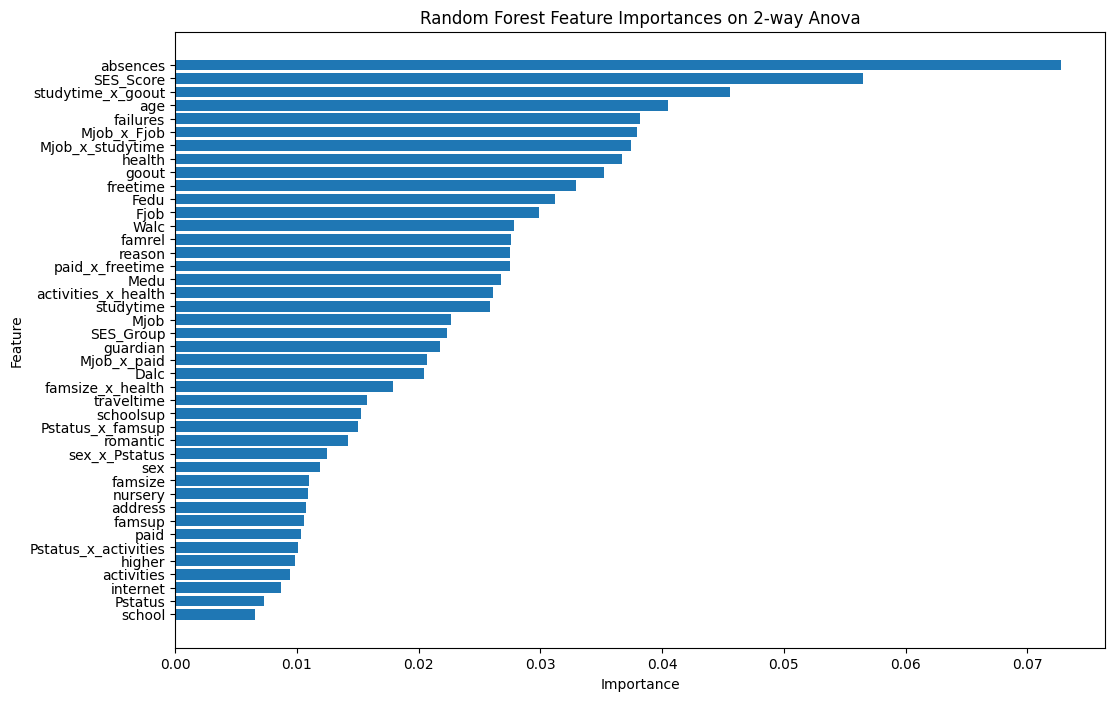

In [ ]:
# Sort the DataFrame and plot by importance
importance_df = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances on 2-way Anova')
plt.gca().invert_yaxis()
plt.show()


## Random Forest Classifier Model


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_top, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
def evaluate_model(model, model_name, X_train, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))
    y_pred_prob = model.predict_proba(X_test)
    print(f'{model_name} Prediction Probabilities (First 5 Predictions):')
    print(y_pred_prob[:5])
    print('-' * 50)

evaluate_model(rf_classifier, 'Random Forest', X_train_top, X_test_top, y_test)

Random Forest Accuracy: 0.5063291139240507
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.78      0.56        32
           1       0.65      0.41      0.50        27
           2       0.80      0.20      0.32        20

    accuracy                           0.51        79
   macro avg       0.63      0.46      0.46        79
weighted avg       0.60      0.51      0.48        79

Random Forest Prediction Probabilities (First 5 Predictions):
[[0.34 0.57 0.09]
 [0.47 0.51 0.02]
 [0.37 0.43 0.2 ]
 [0.66 0.18 0.16]
 [0.39 0.47 0.14]]
--------------------------------------------------


In [ ]:
def evaluate_search(search_obj, search_type, X_test, y_test):
    print(f"Best parameters found by {search_type}: ", search_obj.best_params_)
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print(f'Classification Report of the best model ({search_type}):')
    print(classification_report(y_test, y_pred))
    y_pred_prob = best_model.predict_proba(X_test)
    print(f'Prediction Probabilities (First 5 Predictions) of the best model ({search_type}):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42,
                           class_weight='balanced'),
                           param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,)

grid_search.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search, 'GridSearchCV', X_test_top, y_test)


Best parameters found by GridSearchCV:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy of the best model: 0.5189873417721519
Classification Report of the best model (GridSearchCV):
              precision    recall  f1-score   support

           0       0.45      0.72      0.55        32
           1       0.57      0.44      0.50        27
           2       0.86      0.30      0.44        20

    accuracy                           0.52        79
   macro avg       0.63      0.49      0.50        79
weighted avg       0.59      0.52      0.51        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearchCV):
[[0.34982359 0.59325382 0.05692259]
 [0.43999827 0.48309841 0.07690332]
 [0.36566403 0.55313535 0.08120063]
 [0.66603043 0.20838467 0.1255849 ]
 [0.3916627  0.46876194 0.13957536]]
--------------------------------------------------


In [ ]:
strat_k_fold = StratifiedKFold(n_splits=5)
refined_param_grid = {
    'n_estimators': [90, 100, 110],
    'max_depth': [8, 10, 12],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2, 3]
}
refined_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=refined_param_grid,
    cv=strat_k_fold,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
refined_grid_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(refined_grid_search, 'GridSearchCV', X_test_top, y_test)


Best parameters found by GridSearchCV:  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 110}
Accuracy of the best model: 0.5316455696202531
Classification Report of the best model (GridSearchCV):
              precision    recall  f1-score   support

           0       0.46      0.78      0.58        32
           1       0.65      0.41      0.50        27
           2       0.75      0.30      0.43        20

    accuracy                           0.53        79
   macro avg       0.62      0.50      0.50        79
weighted avg       0.60      0.53      0.51        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearchCV):
[[0.38660307 0.56877546 0.04462147]
 [0.4511039  0.43961634 0.10927976]
 [0.33486204 0.51589262 0.14924535]
 [0.55978078 0.24826654 0.19195267]
 [0.44848204 0.46494471 0.08657325]]
--------------------------------------------------


In [ ]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(random_search, 'RandomizedSearchCV', X_test_top, y_test)

Best parameters found by RandomizedSearchCV:  {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 79}
Accuracy of the best model: 0.5189873417721519
Classification Report of the best model (RandomizedSearchCV):
              precision    recall  f1-score   support

           0       0.45      0.78      0.57        32
           1       0.73      0.41      0.52        27
           2       0.56      0.25      0.34        20

    accuracy                           0.52        79
   macro avg       0.58      0.48      0.48        79
weighted avg       0.58      0.52      0.50        79

Prediction Probabilities (First 5 Predictions) of the best model (RandomizedSearchCV):
[[0.41103695 0.58060537 0.00835768]
 [0.49044215 0.40906102 0.10049683]
 [0.24046632 0.74687545 0.01265823]
 [0.54704727 0.25533491 0.19761783]
 [0.42867931 0.52661852 0.04470217]]
--------------------------------------------------


## ADABoost with Random Forest as Base


In [ ]:
base_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
ada_boost_rf = AdaBoostClassifier(estimator=base_rf, random_state=42, n_estimators=50)
ada_boost_rf.fit(X_train_top, y_train)

In [ ]:
evaluate_model(ada_boost_rf, 'AdaBoost', X_train_top, X_test_top, y_test)

AdaBoost Accuracy: 0.4810126582278481
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.84      0.57        32
           1       0.64      0.33      0.44        27
           2       1.00      0.10      0.18        20

    accuracy                           0.48        79
   macro avg       0.69      0.43      0.40        79
weighted avg       0.65      0.48      0.43        79

AdaBoost Prediction Probabilities (First 5 Predictions):
[[0.41 0.58 0.01]
 [0.46 0.43 0.11]
 [0.4  0.5  0.1 ]
 [0.64 0.19 0.17]
 [0.42 0.49 0.09]]
--------------------------------------------------


In [ ]:
# ada model pipeline
ada_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada_boost_rf', AdaBoostClassifier(
        estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
        random_state=42))
])


In [ ]:
param_dist_ada = {
    'ada_boost_rf__n_estimators': randint(5, 20),
    'ada_boost_rf__learning_rate': [0.01, 0.1, 1]
}
random_search_ada = RandomizedSearchCV(
    ada_pipeline,
    param_distributions=param_dist_ada,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search_ada.fit(X_train_top, y_train)


In [ ]:
evaluate_search(random_search_ada, 'RandomizedSearchCV', X_test_top, y_test)

Best parameters found by RandomizedSearchCV:  {'ada_boost_rf__learning_rate': 1, 'ada_boost_rf__n_estimators': 8}
Accuracy of the best model: 0.4810126582278481
Classification Report of the best model (RandomizedSearchCV):
              precision    recall  f1-score   support

           0       0.44      0.59      0.51        32
           1       0.48      0.37      0.42        27
           2       0.60      0.45      0.51        20

    accuracy                           0.48        79
   macro avg       0.51      0.47      0.48        79
weighted avg       0.49      0.48      0.48        79

Prediction Probabilities (First 5 Predictions) of the best model (RandomizedSearchCV):
[[0.31 0.63 0.06]
 [0.37 0.59 0.04]
 [0.33 0.51 0.16]
 [0.51 0.21 0.28]
 [0.46 0.46 0.08]]
--------------------------------------------------


In [ ]:
param_grid_ada = {
    'ada_boost_rf__n_estimators': [10, 50, 100, 200],
    'ada_boost_rf__learning_rate': [0.01, 0.1, 1],
    'ada_boost_rf__estimator__max_depth': [3, 5, 7],
    'ada_boost_rf__estimator__n_estimators': [10, 50, 100],
}

grid_search_ada = GridSearchCV(
    ada_pipeline,
    param_grid=param_grid_ada,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search_ada.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_ada, 'Gridsearch Ada', X_test_top, y_test)

Best parameters found by Gridsearch Ada:  {'ada_boost_rf__estimator__max_depth': 5, 'ada_boost_rf__estimator__n_estimators': 100, 'ada_boost_rf__learning_rate': 1, 'ada_boost_rf__n_estimators': 50}
Accuracy of the best model: 0.46835443037974683
Classification Report of the best model (Gridsearch Ada):
              precision    recall  f1-score   support

           0       0.42      0.72      0.53        32
           1       0.56      0.33      0.42        27
           2       0.62      0.25      0.36        20

    accuracy                           0.47        79
   macro avg       0.54      0.43      0.43        79
weighted avg       0.52      0.47      0.45        79

Prediction Probabilities (First 5 Predictions) of the best model (Gridsearch Ada):
[[0.37843546 0.41757366 0.20399088]
 [0.37904477 0.41411087 0.20684436]
 [0.37627974 0.37806008 0.24566018]
 [0.41747193 0.30720995 0.27531812]
 [0.38701689 0.39744888 0.21553423]]
--------------------------------------------------


## Logistic Regression

In [ ]:


logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_top, y_train)


In [ ]:
evaluate_model(logreg, 'Logistic Regression', X_train_top, X_test_top, y_test)


Logistic Regression Accuracy: 0.5443037974683544
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.72      0.57        32
           1       0.62      0.48      0.54        27
           2       0.78      0.35      0.48        20

    accuracy                           0.54        79
   macro avg       0.62      0.52      0.53        79
weighted avg       0.60      0.54      0.54        79

Logistic Regression Prediction Probabilities (First 5 Predictions):
[[0.20276887 0.78449142 0.01273971]
 [0.55139399 0.41207101 0.036535  ]
 [0.43459588 0.52218472 0.0432194 ]
 [0.48120599 0.3163679  0.20242611]
 [0.33103438 0.66103443 0.0079312 ]]
--------------------------------------------------


In [ ]:
logreg_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced'))
])

param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_logreg.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_logreg, 'GridSearch LR', X_test_top, y_test)

Best parameters found by GridSearch LR:  {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Accuracy of the best model: 0.5189873417721519
Classification Report of the best model (GridSearch LR):
              precision    recall  f1-score   support

           0       0.55      0.38      0.44        32
           1       0.58      0.52      0.55        27
           2       0.45      0.75      0.57        20

    accuracy                           0.52        79
   macro avg       0.53      0.55      0.52        79
weighted avg       0.54      0.52      0.51        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch LR):
[[0.1043619  0.89417343 0.00146467]
 [0.46733326 0.42251671 0.11015003]
 [0.31729836 0.65062399 0.03207765]
 [0.27045212 0.23627499 0.49327289]
 [0.18726675 0.80976221 0.00297104]]
--------------------------------------------------


In [ ]:

param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']
}

grid_search_logreg2 = GridSearchCV(
    logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_logreg2.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_logreg2, "GridSearchCV LR", X_test_top, y_test)

Best parameters found by GridSearchCV LR:  {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Accuracy of the best model: 0.5189873417721519
Classification Report of the best model (GridSearchCV LR):
              precision    recall  f1-score   support

           0       0.55      0.38      0.44        32
           1       0.58      0.52      0.55        27
           2       0.45      0.75      0.57        20

    accuracy                           0.52        79
   macro avg       0.53      0.55      0.52        79
weighted avg       0.54      0.52      0.51        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearchCV LR):
[[0.1043619  0.89417343 0.00146467]
 [0.46733326 0.42251671 0.11015003]
 [0.31729836 0.65062399 0.03207765]
 [0.27045212 0.23627499 0.49327289]
 [0.18726675 0.80976221 0.00297104]]
--------------------------------------------------


## SVM

In [ ]:
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train_top, y_train)


SVC(probability=True, random_state=42)

In [ ]:
evaluate_model(svm_classifier, 'SVM', X_train_top, X_test_top, y_test)


SVM Accuracy: 0.4177215189873418
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        32
           1       1.00      0.04      0.07        27
           2       0.00      0.00      0.00        20

    accuracy                           0.42        79
   macro avg       0.47      0.35      0.22        79
weighted avg       0.51      0.42      0.26        79

SVM Prediction Probabilities (First 5 Predictions):
[[0.3877449  0.44097501 0.17128009]
 [0.50150676 0.33303697 0.16545627]
 [0.53508701 0.30012704 0.16478595]
 [0.57595707 0.2580119  0.16603103]
 [0.48431514 0.35185111 0.16383375]]
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    #('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])


In [ ]:

param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4]
}

grid_search_svm = GridSearchCV(
    svm_pipeline,
    param_grid=param_grid_svm,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_svm.fit(X_train_top, y_train)

In [ ]:
evaluate_search(grid_search_svm, "SVM", X_test_top, y_test)


Best parameters found by SVM:  {'svm__C': 0.1, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Accuracy of the best model: 0.4810126582278481
Classification Report of the best model (SVM):
              precision    recall  f1-score   support

           0       0.43      0.91      0.59        32
           1       0.75      0.33      0.46        27
           2       0.00      0.00      0.00        20

    accuracy                           0.48        79
   macro avg       0.39      0.41      0.35        79
weighted avg       0.43      0.48      0.40        79

Prediction Probabilities (First 5 Predictions) of the best model (SVM):
[[0.34435209 0.5377087  0.1179392 ]
 [0.54037344 0.31227755 0.14734901]
 [0.46636984 0.39430385 0.13932631]
 [0.53014116 0.29948742 0.17037141]
 [0.41750598 0.47897357 0.10352045]]
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
param_dist_svm = {
    'svm__C': expon(scale=100),
    'svm__kernel': ['rbf', 'poly'],
    'svm__gamma': expon(scale=.1),
    'svm__degree': randint(2, 5)
}
random_search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_dist_svm,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)
random_search_svm.fit(X_train_top, y_train)


In [ ]:
evaluate_search(random_search_svm, "RandomizedSearch SVM", X_test_top, y_test)

Best parameters found by RandomizedSearch SVM:  {'svm__C': 1.5577315371944382, 'svm__degree': 2, 'svm__gamma': 0.05589382770530613, 'svm__kernel': 'rbf'}
Accuracy of the best model: 0.5063291139240507
Classification Report of the best model (RandomizedSearch SVM):
              precision    recall  f1-score   support

           0       0.45      0.81      0.58        32
           1       0.59      0.37      0.45        27
           2       1.00      0.20      0.33        20

    accuracy                           0.51        79
   macro avg       0.68      0.46      0.46        79
weighted avg       0.64      0.51      0.47        79

Prediction Probabilities (First 5 Predictions) of the best model (RandomizedSearch SVM):
[[0.37276261 0.4957804  0.13145699]
 [0.45495889 0.41920391 0.1258372 ]
 [0.49229152 0.38633964 0.12136883]
 [0.51229999 0.29828596 0.18941404]
 [0.44107969 0.41929091 0.13962939]]
--------------------------------------------------


## XGB

In [ ]:
xgb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(objective='multi:softmax', random_state=42))
])


In [ ]:

param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_xgb.fit(X_train_top, y_train)


In [ ]:
evaluate_search(grid_search_xgb, "GridSearch XGB", X_test_top, y_test)

Best parameters found by GridSearch XGB:  {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}
Accuracy of the best model: 0.5063291139240507
Classification Report of the best model (GridSearch XGB):
              precision    recall  f1-score   support

           0       0.45      0.62      0.53        32
           1       0.54      0.48      0.51        27
           2       0.64      0.35      0.45        20

    accuracy                           0.51        79
   macro avg       0.54      0.49      0.50        79
weighted avg       0.53      0.51      0.50        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch XGB):
[[0.22931221 0.76870453 0.00198332]
 [0.04229116 0.95319265 0.00451619]
 [0.16489956 0.82199824 0.01310221]
 [0.94855845 0.01921928 0.03222231]
 [0.36887354 0.62747484 0.00365158]]
--------------------------------------------------


In [ ]:
# reruning gridsearch with the refined parameter grid
param_grid_xgb_refined = {
    'xgb__n_estimators': [100, 300, 500],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb_refined = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb_refined,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search_xgb_refined.fit(X_train_top, y_train)


In [ ]:
evaluate_search(grid_search_xgb_refined, "GridSearch xgb2", X_test_top, y_test)

Best parameters found by GridSearch xgb2:  {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__subsample': 0.9}
Accuracy of the best model: 0.4936708860759494
Classification Report of the best model (GridSearch xgb2):
              precision    recall  f1-score   support

           0       0.44      0.59      0.51        32
           1       0.52      0.48      0.50        27
           2       0.64      0.35      0.45        20

    accuracy                           0.49        79
   macro avg       0.53      0.48      0.49        79
weighted avg       0.52      0.49      0.49        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch xgb2):
[[0.16309717 0.826261   0.01064179]
 [0.35138637 0.61143506 0.03717854]
 [0.31832328 0.65548915 0.02618756]
 [0.7552725  0.10627515 0.13845241]
 [0.16339143 0.8234926  0.01311595]]
--------------------------------------------------


In [ ]:
param_dist_xgb = {
    'xgb__n_estimators': randint(100, 1000),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5),
    'xgb__gamma': uniform(0, 5)
}
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist_xgb,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search_xgb.fit(X_train_top, y_train)

In [ ]:
evaluate_search(random_search_xgb, "GridSearch xgb2", X_test_top, y_test)

Best parameters found by GridSearch xgb2:  {'xgb__colsample_bytree': 0.6424202471887338, 'xgb__gamma': 0.18443473677266398, 'xgb__learning_rate': 0.19286930019396906, 'xgb__max_depth': 4, 'xgb__n_estimators': 319, 'xgb__subsample': 0.5257393756249946}
Accuracy of the best model: 0.5063291139240507
Classification Report of the best model (GridSearch xgb2):
              precision    recall  f1-score   support

           0       0.47      0.62      0.53        32
           1       0.50      0.48      0.49        27
           2       0.70      0.35      0.47        20

    accuracy                           0.51        79
   macro avg       0.56      0.49      0.50        79
weighted avg       0.54      0.51      0.50        79

Prediction Probabilities (First 5 Predictions) of the best model (GridSearch xgb2):
[[0.13847914 0.8565607  0.00496021]
 [0.12097118 0.8689834  0.01004536]
 [0.40092558 0.5823606  0.01671381]
 [0.73047537 0.16100916 0.10851543]
 [0.45163363 0.54054284 0.0078235

## function to return full array of predictions

In [ ]:
def get_model_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob


In [ ]:
def get_search_pred(search_obj, X_test, y_test):
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print("Classification Report of the best model:",{best_model})
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob


In [ ]:
# collecting the data
y_test_gs1, y_pred_gs1, y_pred_prob_gs1 = get_search_pred(refined_grid_search, X_test_top, y_test)
#y_test_gs2, y_pred_gs2, y_pred_prob_gs2 = get_search_pred(logreg, X_test_top, y_test)
y_test1, y_pred1, y_pred_prob1 = get_model_pred(logreg, X_test_top, y_test) # ada
#y_test_gs3, y_pred_gs3, y_pred_prob_gs3 = get_search_pred(grid_search_logreg2, X_test_top, y_test)
y_test_gs4, y_pred_gs4, y_pred_prob_gs4 = get_search_pred(random_search_svm, X_test_top, y_test)
y_test_gs5, y_pred_gs5, y_pred_prob_gs5 = get_search_pred(random_search_xgb, X_test_top, y_test)


Accuracy of the best model: 0.5316455696202531
Classification Report of the best model: {RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=5, n_estimators=110, random_state=42)}
              precision    recall  f1-score   support

           0       0.46      0.78      0.58        32
           1       0.65      0.41      0.50        27
           2       0.75      0.30      0.43        20

    accuracy                           0.53        79
   macro avg       0.62      0.50      0.50        79
weighted avg       0.60      0.53      0.51        79

Accuracy: 0.5443037974683544
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.72      0.57        32
           1       0.62      0.48      0.54        27
           2       0.78      0.35      0.48        20

    accuracy                           0.54        79
   macro avg       0.62      0.52      0.53        79
weighted av

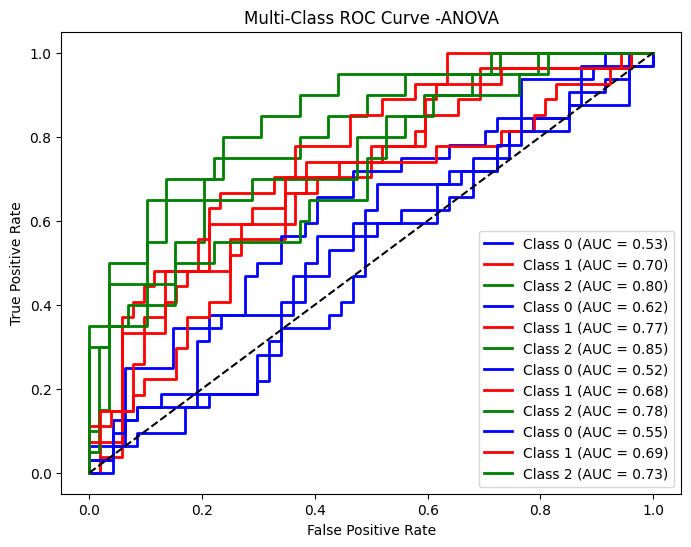

In [ ]:
# Function to plot ROC curve for each class
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

def plot_multiclass_roc(y_true, y_pred_prob, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.figure(figsize=(8, 6))
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs1, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob1, n_classes)
#plot_multiclass_roc(y_test_binarized, y_pred_prob_gs3, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs4, n_classes)
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs5, n_classes)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve -ANOVA')
plt.legend(loc="lower right")
plt.show()


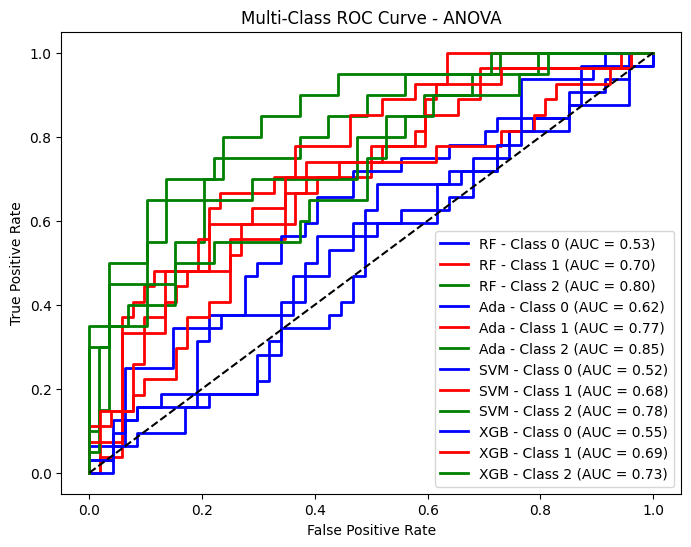

In [ ]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming y_test and prediction probabilities are defined
# ...

# Update the function to include model_label
def plot_multiclass_roc(y_true, y_pred_prob, n_classes, model_label):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{model_label} - Class {i} (AUC = {roc_auc[i]:.2f})')

# Binarize the y_test for multiclass ROC plot
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))

# Plot ROC for each model
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs1, n_classes, 'RF')
plot_multiclass_roc(y_test_binarized, y_pred_prob1, n_classes, 'Ada')
# plot_multiclass_roc(y_test_binarized, y_pred_prob_gs3, n_classes, 'Model GS3')
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs4, n_classes, 'SVM')
plot_multiclass_roc(y_test_binarized, y_pred_prob_gs5, n_classes, 'XGB')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve - ANOVA')
plt.legend(loc="lower right")
plt.show()


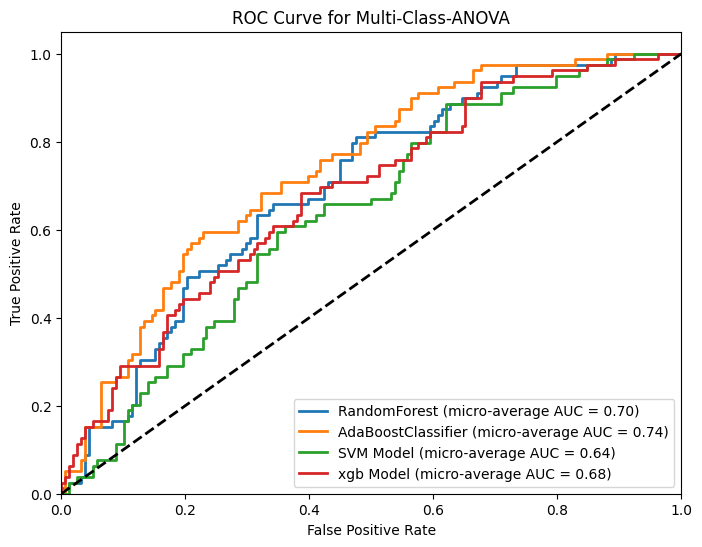

In [ ]:
# Function to plot ROC curve for each model with micro-averaging
def plot_micro_averaged_roc_curve(y_true, y_score, n_classes, ax, name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # micro-average ROC curve & ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"],
            label=f'{name} (micro-average AUC = {roc_auc["micro"]:0.2f})',
            linestyle='-', linewidth=2)


fig, ax = plt.subplots(figsize=(8, 6))
# score arrays from best models
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'RandomForest')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob1, n_classes, ax, 'AdaBoostClassifier')
#plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs3, n_classes, ax, 'LogisticRegression')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs4, n_classes, ax, 'SVM Model')
plot_micro_averaged_roc_curve(y_test_binarized, y_pred_prob_gs5, n_classes, ax, 'xgb Model')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Multi-Class-ANOVA')
ax.legend(loc="lower right")
plt.show()



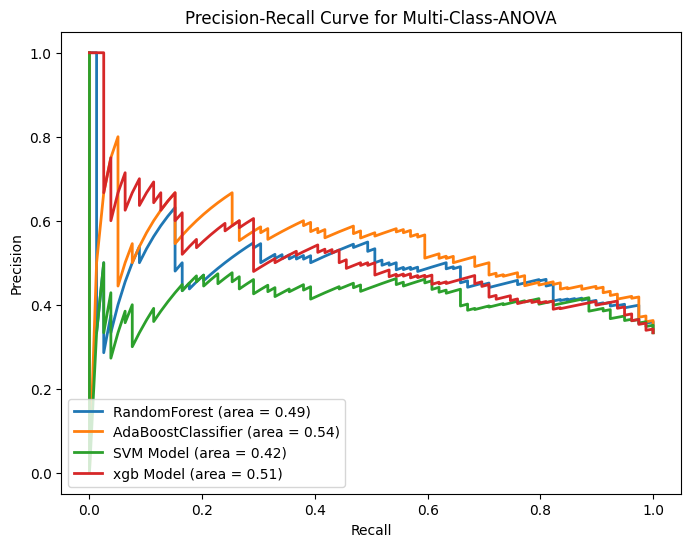

In [ ]:
# Function to plot Precision-Recall curve for each model with micro-averaging
def plot_micro_averaged_precision_recall_curve(y_true, y_score, n_classes, ax, name):
    precision = dict()
    recall = dict()
    average_precision = dict()

    # micro-average precision-recall & AUC
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true, y_score, average="micro")

    ax.plot(recall["micro"], precision["micro"], lw=2,
             label=f'{name} (area = {average_precision["micro"]:0.2f})')

fig, ax = plt.subplots(figsize=(8, 6))
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs1, n_classes, ax, 'RandomForest')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob1, n_classes, ax, 'AdaBoostClassifier')
#plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs3, n_classes, ax, 'LogisticRegression')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs4, n_classes, ax, 'SVM Model')
plot_micro_averaged_precision_recall_curve(y_test_binarized, y_pred_prob_gs5, n_classes, ax, 'xgb Model')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for Multi-Class-ANOVA')
ax.legend(loc="lower left")
plt.show()

In [ ]:
# function to plot the confusion matrix of best models
def plot_confusion_matrix(cm, classes, title, ax, cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, ax=ax, cmap=cmap)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
class_labels = np.unique(y_test)
predictions = [
    (y_test_gs1, y_pred_gs1, 'RF'),
    (y_test1, y_pred_prob1, 'Ada'),
   # (y_test_gs3, y_pred_gs3, 'Grid Search LogReg 2'),
    (y_test_gs4, y_pred_gs4, 'SVM'),
    (y_test_gs5, y_pred_gs5, 'XGB'),
]

for i, (y_test, y_pred, title) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes.flat[i]
    plot_confusion_matrix(cm, class_labels, title, ax)
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()
#RF, ada, svm, xgb

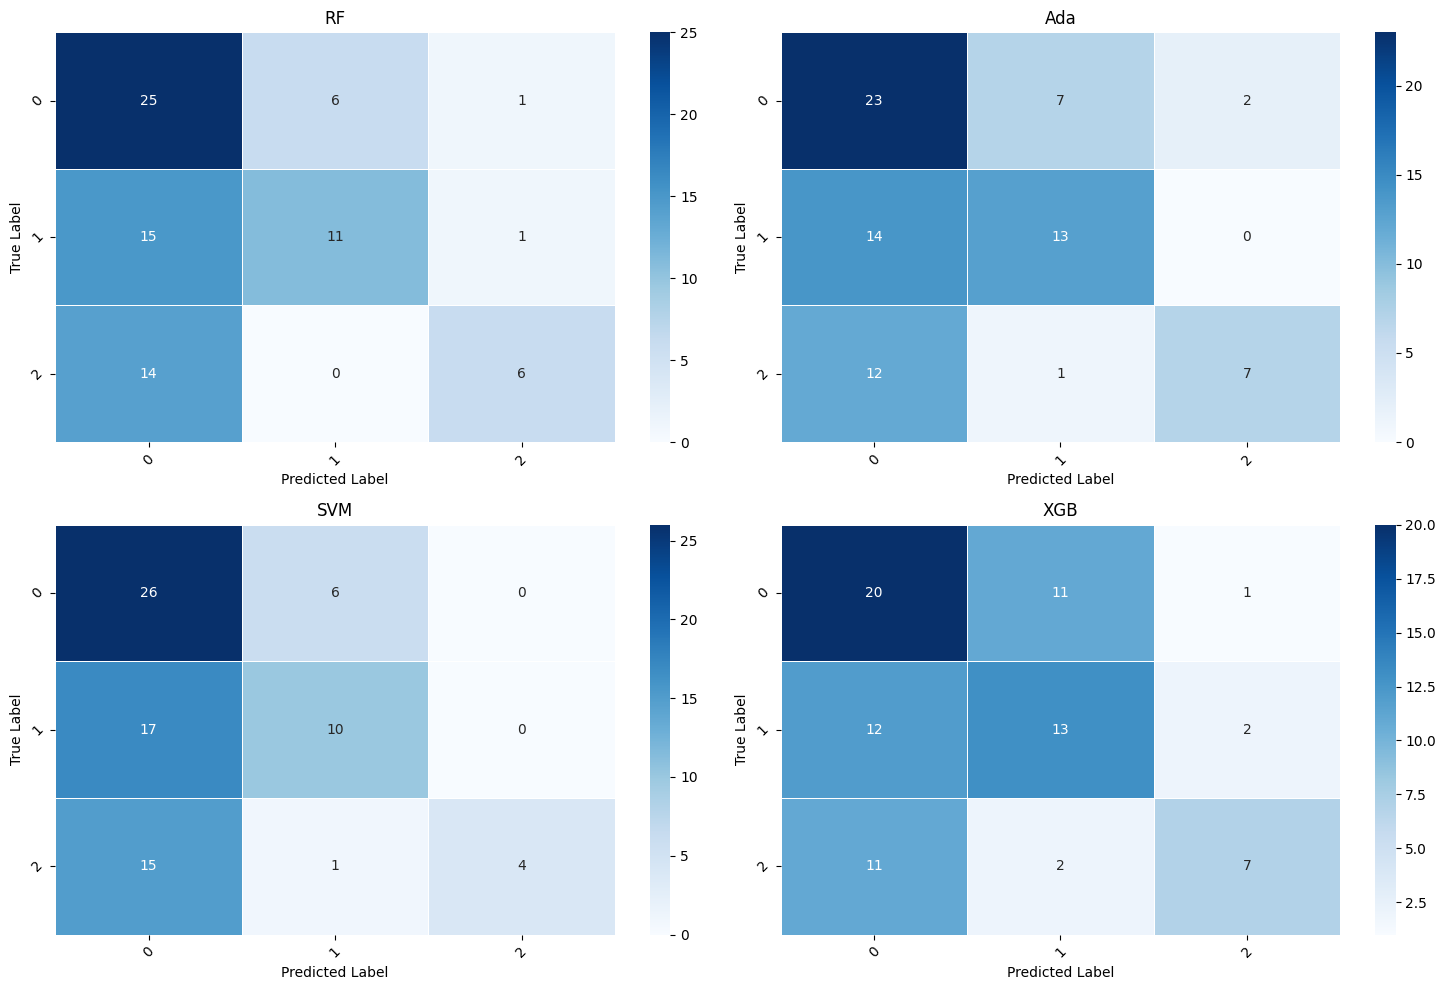

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Function to plot the confusion matrix of best models
def plot_confusion_matrix(cm, classes, title, ax, cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, ax=ax, cmap=cmap)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes, rotation=45)

# List of predictions to plot
predictions = [
    (y_test_gs1, y_pred_gs1, 'RF'),
    (y_test1, y_pred1, 'Ada'),
    (y_test_gs4, y_pred_gs4, 'SVM'),
    (y_test_gs5, y_pred_gs5, 'XGB'),
]

class_labels = np.unique(np.concatenate([y_test_gs1, y_test1, y_test_gs4, y_test_gs5]))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot each confusion matrix
for i, (y_test, y_pred, title) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes.flat[i]
    plot_confusion_matrix(cm, class_labels, title, ax)
for j in range(i+1, 4):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()
